In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from tqdm.notebook import tqdm
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')

In [3]:
#os.chdir("MLImages")

In [4]:
#os.chdir("My Drive")

In [5]:
#os.chdir("Images")

In [6]:
#os.chdir("Images_ml")

In [8]:
print(os.getcwd())

/home/arnv/Documents/ML Final Exam/MLImages


In [9]:
path = '/home/arnv/Documents/ML Final Exam/MLImages'

In [10]:
file_list=[]

In [11]:
I = np.zeros((501,288,360,3))

In [12]:
for r,d,f in os.walk(path):
    for file in f:
        if ".bmp" in file:
            file_list.append(os.path.join(r,file))

In [13]:
file_list=sorted(file_list)

In [14]:
for t in range(0,501):
    img = cv2.imread(file_list[t])
    I[t] = img

In [15]:
M = np.zeros((501,288,360,3))

In [16]:
V = np.zeros((501,288,360,3))

In [17]:
B = {}

In [18]:
M[0] = I[0]
V[0,:,:,:] = 9

In [19]:
D = np.zeros((505,288,360,3))

In [20]:
lamda = [0.5,1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [21]:
C = np.zeros((8,501,288,360))

# Foreground Detection 

In [22]:
A = np.zeros((501, 292, 364))

In [23]:
v_C = np.zeros((8,501,288,360))

In [24]:
n_v = 0.6

In [25]:
alpha = np.zeros((501,1))

In [26]:
F = np.zeros((501,288,360))

In [27]:
t_c= 100

In [29]:
epoches = 1
images =  len(I)
total_lamda = 8
for l in tqdm_notebook(range(0,total_lamda), total =total_lamda, unit="lambda"): 
    for t in range(1,images):        
        # Foreground Detection
        for x in range(2,290):
          for y in range(2,362):
              D[t,x-2,y-2,:] = I[t,x-2,y-2,:] - M[t-1,x-2,y-2,:]
              a = (D[t,x-2,y-2,:]**2 <= (lamda[l]**2)*V[t-1,x-2,y-2,:])
              #print(a)
              if(a[0] and a[1] and a[2]):
                    C[l,t,x-2,y-2] =  0
              else:
                    C[l,t,x-2,y-2] = 255
        # Detection of noise
        C_pad = np.pad(C[l,t],((2,2),(2,2)),'constant')
        for x in range(2,290):
           for y in range(2,362):
              window = C_pad[x-2:x+3,y-2:y+3]
              count = np.sum(window/255)
              F[t,x-2,y-2] = float(count)
              if(F[t,x-2,y-2]/25 > n_v):
                  v_C[l,t,x-2,y-2]=255
              else:
                  v_C[l,t,x-2,y-2]=0
        # Model Update
              if(t<=t_c):
                 alpha[t]=1.0/(t+1)
              else:
                 alpha[t]=1.0/t_c
              if (v_C[l,t,x-2,y-2] ==0):
                 kro = 1
              else:
                 kro = 0
              M[t,x-2,y-2,:] = M[t-1,x-2,y-2,:] + kro*alpha[t]*D[t,x-2,y-2,:]
              if ((v_C[l,t,x-2,y-2]-255) ==0):
                 kro_255 = 1
              else:
                 kro_255 = 0
              V[t,x-2,y-2,:] = kro_255*(V[t-1,x-2,y-2,:]) + kro*((1-alpha[t])*(V[t-1,x-2,y-2,:] + alpha[t]*(D[t,x-2,y-2,:])**2)) 
            
            

/home/arnv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


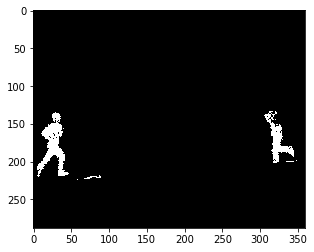

In [33]:
plt.imshow((C[7,15,:,:]),cmap="gray")

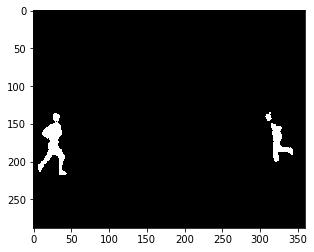

In [32]:
plt.imshow((v_C[7,15,:,:]),cmap="gray")

# ROC Curve

In [34]:
file_ground_truth = []

In [35]:
os.getcwd()

'/home/arnv/Documents/ML Final Exam/MLImages'

In [36]:
#os.chdir("..")

In [38]:
#os.chdir("BakSubGroundTruth")

In [39]:
path_background = '/home/arnv/Documents/ML Final Exam/BakSubGroundTruth'

In [40]:
for r,d,f in os.walk(path_background):
    for file in f:
        if ".bmp" in file:
            file_ground_truth.append(os.path.join(r,file))

In [41]:
file_ground_truth=sorted(file_ground_truth)

In [42]:
Ground_truth = np.zeros((len(file_ground_truth),288,360))

In [45]:
for t in range(0,501):
    img = cv2.imread(file_ground_truth[t],0)
    Ground_truth[t] = img

In [49]:
Ground_truth_vector = Ground_truth.flatten()

In [50]:
sensitivity = []
false_positive_rate = []

In [51]:
lamda = 8
for i in tqdm_notebook(range(0,8), total=lamda, unit="lambda"):
    v_C_vector = v_C[i].flatten()
    tn, fp, fn, tp = confusion_matrix(Ground_truth_vector,v_C_vector,labels=[0,255]).ravel()
    sensitivity.append(tp/(tp+fn))
    false_positive_rate.append(fp/(fp+tn))

/home/arnv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


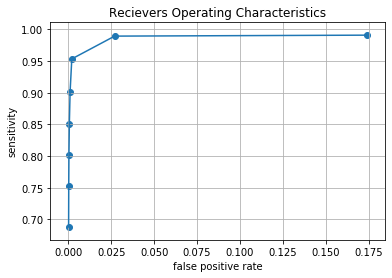

In [56]:
plt.plot(false_positive_rate,sensitivity)
plt.scatter(false_positive_rate,sensitivity)
plt.title("Recievers Operating Characteristics")
plt.xlabel("false positive rate")
plt.ylabel("sensitivity")
plt.grid()
plt.show()